## Machine Learning - Online Payments Fraud Detection

In [1]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# exploring transaction type
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [15]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

In [16]:
import plotly.express as px

fig = px.pie(data,
             values=quantity,
             names=transactions, hole = 0.5,
             title="Distribution of Transaction Type")

fig.show()

In [25]:
# Checking correlation to see which data features correlates with isFraud column
correlation = data.corr(numeric_only=True)
print(correlation["isFraud"].sort_values(ascending=False))

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [36]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 10.7 MB/s eta 0:00:0000:0100:01
  Using cached contourpy-1.0.7-cp310-cp310-macosx_11_0_arm64.whl (229 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.4-cp310-cp310-macosx_11_0_arm64.whl (63 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.4 MB/s eta 0:00:0000:0100:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
Note: you may need to restart the kernel to use updated packages.


/var/folders/7h/wcx83fxj7x97msw2zx_024t40000gq/T/ipykernel_67470/2025000298.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

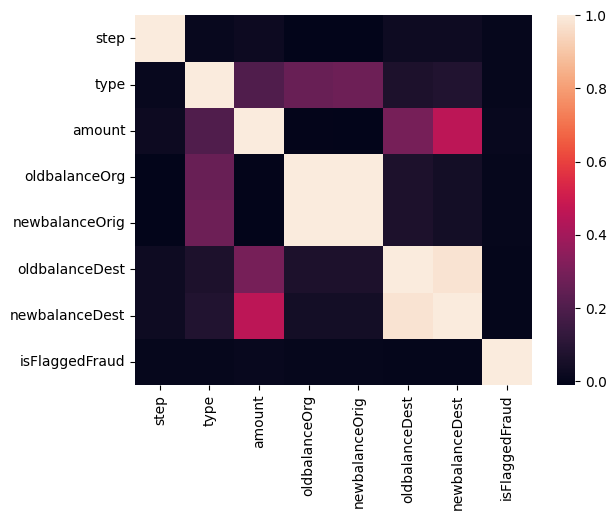

In [37]:
from seaborn import heatmap

heatmap(data.corr())

In [26]:
# transform the values of the isFraud column into No Fraud and Fraud labels

data["type"] = data["type"].map({"CASH_OUT":1,
                                 "PAYMENT":2,
                                 "CASH_IN":3,
                                 "TRANSFER":4,
                                 "DEBIT":5})

data["isFraud"] = data["isFraud"].map({0:"No Fraud",
                                       1:"Fraud"})

print(data.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0  No Fraud               0  
1  M2044282225             0.0             0.0  No Fraud               0  
2   C553264065             0.0             0.0     Fraud               0  
3    C38997010         21182.0             0.0     Fraud               0  
4  M1230701703             0.0             0.0  No Fraud               0  


### Fraud Detection Model

In [27]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 11.3 MB/s eta 0:00:0000:0100:01
  Using cached scipy-1.10.1-cp310-cp310-macosx_12_0_arm64.whl (28.8 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Splitting data to train and test sets
from sklearn.model_selection import train_test_split

x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[["isFraud"]])

#### Decision Tree Classifier

In [30]:
# Training ML model with Decision tree
from sklearn.tree import DecisionTreeClassifier

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=42)
model=DecisionTreeClassifier()
model.fit(xtrain, ytrain)

print(model.score(xtest, ytest))


0.9997280994307377


In [33]:
# prediction
# features = [type, amount, oldbalanceOrg, newbalanceOrig]

# transfer mapping
features = np.array([[4, 9000.60, 9000.10, 0.0]])
print(model.predict(features))

['Fraud']


In [35]:
# cash out mapping
features = np.array([[1, 5000.60, 0.0, 5000.60]])
print(model.predict(features))

['No Fraud']


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(xtrain, ytrain)
print(RF.score(xtest, ytest))